In [81]:
# @title Install Packages
# @markdown You might have to run this twice. It may ask you to reset the session, so just do that and run it again. Still working out the kinks here but the most important thing is to make sure dssp is installed.
!pip install --upgrade \
    numpy \
    pandas \
    matplotlib \
    scipy \
    scikit-learn \
    biopython \
    py3Dmol \
    hdxrate > /dev/null 2>&1

!apt-get update && apt-get install -y dssp > /dev/null 2>&1

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [82]:
# @title Imports
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
except ImportError:
    print("Not running in Google Colab. Skipping drive mount.")

import json, math, os, tempfile, warnings
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
from Bio.PDB import PDBParser, PPBuilder, DSSP
from Bio.PDB.SASA import ShrakeRupley
from hdxrate import k_int_from_sequence
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import shutil


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import py3Dmol

Mounted at /content/drive
Google Drive mounted successfully.


In [83]:
# @title D2O Exchange Simulation Setup (Stage 1)
# @markdown The following code block provides interactive widgets for configuring the
# @markdown D2O exchange simulation. You can use the default values provided for the
# @markdown example files or update them with your own file paths and parameters.

mount_drive_button = widgets.Button(description="Mount Google Drive")
mount_output = widgets.Output()

def on_mount_drive_button_clicked(b):
    """
    Callback function to handle the Google Drive mount button click.
    Clears the output and mounts the Google Drive to '/content/drive'.
    """
    with mount_output:
        clear_output()
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
        print("Google Drive mounted at /content/drive")

mount_drive_button.on_click(on_mount_drive_button_clicked)

# Display the mount button and output area
display(mount_drive_button, mount_output)

# Text widgets for user to enter file paths
# These are pre-filled with example paths for convenience.
pdb_path_input = widgets.Text(
    value='/content/drive/MyDrive/D2O/cytochrome_c_bound/cytrochrome_c_heme_bound_alphafold.pdb',
    placeholder='Enter the full path to your .pdb file',
    description='PDB File Path:',
    layout=widgets.Layout(width='auto')
)

json_path_input = widgets.Text(
    value='/content/drive/MyDrive/D2O/cytochrome_c_bound/stage_1_coefficients.json',
    placeholder='Enter the full path to your .json file',
    description='JSON File Path:',
    layout=widgets.Layout(width='auto')
)

# Output directory and system label widgets
output_dir_name = widgets.Text(
    value='cytochrome_c_predictions',
    placeholder='Type a name for the output directory',
    description='Output Dir Name:'
)
system_label = widgets.Text(
    value='cytochrome_c_bound',
    placeholder='Type a label for your system',
    description='System Label:'
)

# --- Environmental Conditions Widgets ---
# Widgets for setting simulation parameters like temperature, pH, etc.
temperature_input = widgets.FloatText(
    value=293.15,
    description='Temperature (K):',
    min=0.0
)
ph_read_input = widgets.FloatText(
    value=7.0,
    description='pH Read:',
    min=0.0,
    max=14.0
)
ph_correction_input = widgets.Checkbox(
    value=True,
    description='pH Correction:'
)
exchange_type_input = widgets.Dropdown(
    options=['HD', 'HX'],
    value='HD',
    description='Exchange Type:',
    layout=widgets.Layout(width='300px') # Adjusted width to prevent text cutoff
)
d_percentage_input = widgets.FloatText(
    value=90.0,
    description='D Percentage (%):'
)

# A button to confirm all selections and set variables
confirm_button = widgets.Button(description="Confirm All Settings")
output_area = widgets.Output()

# Global variables that will be populated with the widget values.
PDB_FILE = None
STAGE1_JSON = None
OUT_DIR = None
SYSTEM_LABEL = None
TEMPERATURE = None
PH_READ = None
PH_CORRECTION = None
EXCHANGE_TYPE = None
D_PERCENTAGE = None

def on_confirm_button_clicked(b):
    """
    Callback function for the confirm button.
    It reads all the widget values, validates the file paths, and sets the
    global variables for use in subsequent cells of the notebook.
    """
    global PDB_FILE, STAGE1_JSON, OUT_DIR, SYSTEM_LABEL
    global TEMPERATURE, PH_READ, PH_CORRECTION, EXCHANGE_TYPE, D_PERCENTAGE

    with output_area:
        clear_output()

        # --- Update File Paths ---
        pdb_path = pdb_path_input.value
        json_path = json_path_input.value

        if not Path(pdb_path).exists():
            print(f"Error: PDB file not found at {pdb_path}")
            return
        if not Path(json_path).exists():
            print(f"Error: JSON file not found at {json_path}")
            return

        PDB_FILE = Path(pdb_path)
        STAGE1_JSON = Path(json_path)
        OUT_DIR = PDB_FILE.parent / output_dir_name.value
        SYSTEM_LABEL = system_label.value
        OUT_DIR.mkdir(parents=True, exist_ok=True)

        # --- Update Environmental Variables ---
        TEMPERATURE = temperature_input.value
        PH_READ = ph_read_input.value
        PH_CORRECTION = ph_correction_input.value
        EXCHANGE_TYPE = exchange_type_input.value
        d_percent_value = d_percentage_input.value
        if 0.0 <= d_percent_value <= 100.0:
            D_PERCENTAGE = d_percent_value
        else:
            print(f"Warning: D Percentage value {d_percent_value} is not between 0 and 100. Using default of 95.0.")
            D_PERCENTAGE = 95.0

        print("--- File Paths and System Configuration ---")
        print(f"PDB file set to: {PDB_FILE}")
        print(f"JSON file set to: {STAGE1_JSON}")
        print(f"Output directory set to: {OUT_DIR}")
        print(f"System label set to: {SYSTEM_LABEL}")

        print("\n--- Environmental Conditions ---")
        print(f"Temperature: {TEMPERATURE} K")
        print(f"pH Read: {PH_READ}")
        print(f"pH Correction: {PH_CORRECTION}")
        print(f"Exchange Type: {EXCHANGE_TYPE}")
        print(f"D Percentage: {D_PERCENTAGE} %")

        print("\nAll settings have been configured. You can now run the rest of your notebook.")

confirm_button.on_click(on_confirm_button_clicked)

# Display all the widgets in a structured way
print("--- File Paths and System Configuration ---")
display(pdb_path_input, json_path_input, output_dir_name, system_label)
print("\n--- Environmental Conditions ---")
display(temperature_input, ph_read_input, ph_correction_input, exchange_type_input, d_percentage_input)
display(confirm_button, output_area)


Button(description='Mount Google Drive', style=ButtonStyle())

Output()

--- File Paths and System Configuration ---


Text(value='/content/drive/MyDrive/D2O/cytochrome_c_bound/cytrochrome_c_heme_bound_alphafold.pdb', description…

Text(value='/content/drive/MyDrive/D2O/cytochrome_c_bound/stage_1_coefficients.json', description='JSON File P…

Text(value='cytochrome_c_predictions', description='Output Dir Name:', placeholder='Type a name for the output…

Text(value='cytochrome_c_bound', description='System Label:', placeholder='Type a label for your system')


--- Environmental Conditions ---


FloatText(value=293.15, description='Temperature (K):')

FloatText(value=7.0, description='pH Read:')

Checkbox(value=True, description='pH Correction:')

Dropdown(description='Exchange Type:', layout=Layout(width='300px'), options=('HD', 'HX'), value='HD')

FloatText(value=90.0, description='D Percentage (%):')

Button(description='Confirm All Settings', style=ButtonStyle())

Output()

In [84]:
# @title Residue-Level Feature Engineering
EPS, PLDDT_SCALE, CUTOFF = 1e-8, 100.0, 9.0

# 3-letter to 1-letter amino acid code mapping, including common protonation states
THREE_TO_ONE = {
    'ALA':'A','CYS':'C','ASP':'D','GLU':'E','PHE':'F','GLY':'G','HIS':'H',
    'ILE':'I','LYS':'K','LEU':'L','MET':'M','ASN':'N','PRO':'P','GLN':'Q',
    'ARG':'R','SER':'S','THR':'T','VAL':'V','TRP':'W','TYR':'Y',
    'HIE':'H','HIP':'H','HID':'H','CYM':'C','AS4':'D','GL4':'E','ASH':'D'
}
# Kyte-Doolittle hydrophobicity scale
KYTE = {'ALA':1.8,'ARG':-4.5,'ASN':-3.5,'ASP':-3.5,'CYS':2.5,'GLN':-3.5,
        'GLU':-3.5,'GLY':-0.4,'HIS':-3.2,'ILE':4.5,'LEU':3.8,'LYS':-3.9,
        'MET':1.9,'PHE':2.8,'PRO':-1.6,'SER':-0.8,'THR':-0.7,'TRP':-0.9,
        'TYR':-1.3,'VAL':4.2}
# Amino acid charge at neutral pH
CHARGE = {'ALA':0,'ARG':1,'ASN':0,'ASP':-1,'CYS':0,'GLN':0,'GLU':-1,'GLY':0,
          'HIS':0.1,'ILE':0,'LEU':0,'LYS':1,'MET':0,'PHE':0,'PRO':0,'SER':0,
          'THR':0,'TRP':0,'TYR':0,'VAL':0}
# Amino acid molecular weights
MW = {'ALA':89.1,'ARG':174.2,'ASN':132.1,'ASP':133.1,'CYS':121.0,'GLN':146.1,
      'GLU':147.1,'GLY':75.1,'HIS':155.2,'ILE':131.2,'LEU':131.2,'LYS':146.2,
      'MET':149.2,'PHE':165.2,'PRO':115.1,'SER':105.1,'THR':119.1,
      'TRP':204.2,'TYR':181.2,'VAL':140.0}
# Amino acid residue volumes
VOL = {'ALA':88.6,'ARG':173.4,'ASN':114.1,'ASP':111.1,'CYS':108.5,'GLN':143.8,
       'GLU':138.4,'GLY':60.1,'HIS':153.2,'ILE':166.7,'LEU':166.7,'LYS':168.6,
       'MET':149.2,'PHE':189.9,'PRO':112.7,'SER':89.0,'THR':116.1,
       'TRP':227.8,'TYR':193.6,'VAL':140.0}

def environment_df(pdb_path: Path) -> pd.DataFrame:
    """Residue-level geometric & physicochemical context (first chain only)."""
    parser = PDBParser(QUIET=True)
    struct = parser.get_structure("prot", pdb_path)
    model  = struct[0]
    chain  = next(iter(model))
    ShrakeRupley().compute(struct)

    # --- basic indices ------------------------------------------------------
    idx, name, ca = [], [], {}
    for res in chain:
        if res.id[0] == " " and "CA" in res:
            i = res.id[1]
            idx.append(i)
            name.append(res.get_resname())
            ca[i] = res["CA"].coord
    df = pd.DataFrame({"res_idx": idx, "res_name_dump": name})

    # --- neighbour metrics --------------------------------------------------
    all_ca = np.vstack([r["CA"].coord
                        for ch in model
                        for r in ch
                        if r.id[0] == " " and "CA" in r])
    for i in df.res_idx:
        d = np.linalg.norm(all_ca - ca[i], axis=1)
        m = d > 0
        df.loc[df.res_idx == i, "E_count"]   = np.count_nonzero((d < CUTOFF) & m)
        df.loc[df.res_idx == i, "E_invdist"] = float(np.sum(1.0 / (d[m] + EPS)))

    # --- SASA (Shrake-Rupley) ----------------------------------------------
    df["E_sasa"] = [
        float(sum(a.sasa for a in r if hasattr(a, "sasa")))
        for r in chain if r.id[0] == " "
    ]

    # --- dihedrals ----------------------------------------------------------
    phi, psi = {}, {}
    for pep in PPBuilder().build_peptides(chain):
        for res, (p, q) in zip(pep, pep.get_phi_psi_list()):
            phi[res.id[1]] = p
            psi[res.id[1]] = q
    df["phi"] = df.res_idx.map(phi)
    df["psi"] = df.res_idx.map(psi)

    # --- pLDDT --------------------------------------------------------------
    plddt = {r.id[1]: float(np.mean([a.get_bfactor() for a in r]))
             for r in chain if r.id[0] == " "}
    df["plddt"] = df.res_idx.map(plddt)

    # --- DSSP (secondary structure & H-bond count) --------------------------
    with tempfile.NamedTemporaryFile("w+", suffix=".pdb") as tmp:
        pdb_txt = Path(pdb_path).read_text()
        if not pdb_txt.startswith("HEADER"):
            tmp.write("HEADER     DUMMY\n")
        if "CRYST1" not in pdb_txt[:300]:
            tmp.write("CRYST1   60.000   60.000   60.000  90.00  90.00  90.00 P 1           1\n")
        tmp.write(pdb_txt); tmp.flush()
        try:
            dssp = DSSP(model, tmp.name, dssp="mkdssp").property_dict
            ss = {k[1][1]: v[1] for k, v in dssp.items() if k[0] == chain.id}
            hb = {k[1][1]: int(v[5] < -0.5) + int(v[6] < -0.5)
                  for k, v in dssp.items() if k[0] == chain.id}
        except Exception as e:
            warnings.warn(f"DSSP failed: {e}")
            ss, hb = {}, {}
    df["sec_struct"]  = df.res_idx.map(ss).fillna("")
    df["hbond_count"] = df.res_idx.map(hb).fillna(0).astype(int)

    # --- backbone intrinsic exchange (kint) ---------------------------------
    seq, ordering = "", []
    for r in chain:
        if r.id[0] != " ":
            continue
        seq += THREE_TO_ONE.get(r.get_resname(), "X")
        ordering.append(r.id[1])

    kin = k_int_from_sequence(
        seq, TEMPERATURE, PH_READ,
        reference="poly",
        exchange_type=EXCHANGE_TYPE,
        d_percentage=D_PERCENTAGE,
        ph_correction=PH_CORRECTION,
    )
    df["log_k_intrinsic"] = df.res_idx.map(
        {i: math.log(k * 60.0) if k > 0 else np.nan
         for i, k in zip(ordering, kin)}
    )

    # --- constants ----------------------------------------------------------
    df["temperature"]  = TEMPERATURE
    df["pH"]           = PH_READ
    df["D_percentage"] = D_PERCENTAGE
    df["system"]       = SYSTEM_LABEL
    return df


def engineer(df: pd.DataFrame,
             stats: dict,
             feats: List[str],
             center: np.ndarray,
             scale:  np.ndarray) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Replicates the **exact** feature-engineering pipeline used in training.
    Do **not** change anything unless you re-train the Ridge models.
    """
    # unpack stats -----------------------------------------------------------
    Emax, q25, q75 = stats["E_sasa_max"], stats["E_sasa_q25"], stats["E_sasa_q75"]
    hmax, cmax     = stats["hydro_abs_max"], stats["charge_abs_max"]
    mmax, vmax     = stats["mw_max"],    stats["vol_max"]

    df = df.copy()

    # 1. primary transforms --------------------------------------------------
    df["E_sasa_clipped"] = df.E_sasa.clip(EPS)
    df["ln_E_sasa"]      = np.log(df.E_sasa_clipped)
    df["sqrt_E_sasa"]    = np.sqrt(df.E_sasa_clipped)
    df["E_sasa_norm"]    = df.E_sasa_clipped / (Emax + EPS)

    df["hydrophobicity"] = df.res_name_dump.map(KYTE).fillna(0.0)
    df["charge"]         = df.res_name_dump.map(CHARGE).fillna(0.0)
    df["mol_weight"]     = df.res_name_dump.map(MW).fillna(120.0)
    df["volume"]         = df.res_name_dump.map(VOL).fillna(120.0)

    df["hydro_norm"]  = df.hydrophobicity / (hmax or 1.0)
    df["charge_norm"] = df.charge         / (cmax or 1.0)
    df["mw_norm"]     = df.mol_weight     / (mmax or 1.0)
    df["vol_norm"]    = df.volume         / (vmax or 1.0)

    df["ln_E_count"]   = np.log(df.E_count.clip(EPS))
    df["ln_E_invdist"] = np.log(df.E_invdist.clip(EPS))

    df["T_raw"]  = df.temperature
    df["pH_raw"] = df.pH
    df["D_frac"] = df.D_percentage / 100.0

    # burial masks -----------------------------------------------------------
    df["buried"]      = (df.E_sasa <  q25).astype(float)
    df["exposed"]     = (df.E_sasa >  q75).astype(float)
    df["semi_buried"] = ((df.E_sasa >= q25) & (df.E_sasa <= q75)).astype(float)

    # polynomial / interaction terms ----------------------------------------
    df["ln_E_sasa_sq"] = df.ln_E_sasa ** 2
    df["ln_E_sasa_cu"] = df.ln_E_sasa ** 3
    df["hydro_sq"]     = df.hydrophobicity ** 2
    df["hydro_cu"]     = df.hydrophobicity ** 3
    df["E_count_sq"]   = df.E_count ** 2
    df["E_invdist_sq"] = df.E_invdist ** 2

    df["sasa_hydro"]   = df.ln_E_sasa * df.hydrophobicity
    df["sasa_charge"]  = df.ln_E_sasa * df.charge
    df["sasa_mw"]      = df.ln_E_sasa * df.mw_norm
    df["sasa_vol"]     = df.ln_E_sasa * df.vol_norm
    df["hydro_charge"] = df.hydrophobicity * df.charge
    df["count_invdist"]= df.E_count * df.E_invdist
    df["sasa_count"]   = df.ln_E_sasa * df.E_count
    df["sasa_invdist"] = df.ln_E_sasa * df.E_invdist

    df["sin_phi"], df["cos_phi"] = np.sin(df.phi), np.cos(df.phi)
    df["sin_psi"], df["cos_psi"] = np.sin(df.psi), np.cos(df.psi)

    # 3. one-hot secondary structure ----------------------------------------
    cats = stats["sec_struct_categories"]
    df["sec_struct"] = pd.Categorical(df.sec_struct, categories=cats)
    ss = pd.get_dummies(df.sec_struct, prefix="ss", dtype=float)
    # ensure column for every category
    for c in cats:
        col = f"ss_{c}"
        if col not in ss.columns:
            ss[col] = 0.0
    df = pd.concat([df, ss], axis=1)

    # 4. misc ---------------------------------------------------------------
    df["hbond_count_norm"] = df.hbond_count / (stats["hbond_count_max"] or 1.0)
    df["hbond_count_sq"]   = df.hbond_count ** 2

    df["plddt_norm"] = df.plddt / PLDDT_SCALE
    df["plddt_sq"]   = df.plddt_norm ** 2

    df["sasa_plddt"]  = df.ln_E_sasa     * df.plddt_norm
    df["hbond_plddt"] = df.hbond_count_norm * df.plddt_norm
    df["phi_plddt"]   = df.sin_phi * df.plddt_norm

    df["log_k_intrinsic_feat"] = df.log_k_intrinsic.fillna(0.0)

    # 5. design matrix -------------------------------------------------------
    X = pd.DataFrame({f: df.get(f, 0.0) for f in feats})
    X_scaled = (X.values - center) / scale
    return df, X_scaled


def predict_rates_weights(X: np.ndarray,
                          ridge: dict,
                          targets: List[str]) -> np.ndarray:
    """Vectorised Ridge inference with exp-link to keep outputs positive."""
    return np.column_stack([
        np.exp(ridge[t]["int"] + X.dot(ridge[t]["coef"])).clip(min=EPS)
        for t in targets
    ])


def residue_uptake_at_times(rates, weights, t_points, exch_flag):
    """
    Calculate theoretical residue-level uptake over time points based on
    exchange rates and weights.
    """
    r = np.asarray(rates,   dtype=float).reshape(-1, 1)
    w = np.asarray(weights, dtype=float).reshape(-1, 1)
    t = np.asarray(t_points, dtype=float).reshape(1, -1)
    return (w * (1.0 - np.exp(-r * t))).sum(axis=0) * float(exch_flag)

In [85]:
# @title Run Stage 1 Inference
store   = json.loads(Path(STAGE1_JSON).read_text())
FEATS   = store["feature_order"]
TARGETS = store["target_order"]

CENTER  = np.array(store["scaler_center"])
SCALE   = np.array(store["scaler_scale"])

STATS   = {k: store[k] for k in (
           "E_sasa_max","E_sasa_q25","E_sasa_q75",
           "hydro_abs_max","charge_abs_max",
           "mw_max","vol_max",
           "sec_struct_categories","hbond_count_max")}

RIDGE = {
    est["target"]: {
        "coef": np.array([est["coefficients"].get(f, 0.0) for f in FEATS]),
        "int" : est["intercept"]
    } for est in store["estimators"]
}

print("   → computing environment features …")
env_raw = environment_df(PDB_FILE)

print("   → engineering + scaling features …")
env_feat, X_scaled = engineer(env_raw, STATS, FEATS, CENTER, SCALE)

print("   → predicting 8 parameters (4 rates + 4 weights) …")
pred_mat = predict_rates_weights(X_scaled, RIDGE, TARGETS)

preds = pd.DataFrame(
    pred_mat,
    columns=[f"rate_{i+1}"   for i in range(4)] +
            [f"weight_{i+1}" for i in range(4)]
)

print("✅  Stage-1 inference complete.")

out_dict = {
    "system": SYSTEM_LABEL,
    "pdb_file": str(PDB_FILE),
    "global_parameters": {
        "temperature_K": TEMPERATURE,
        "pH_read":       PH_READ,
        "d_percentage":  D_PERCENTAGE,
        "exchange_type": EXCHANGE_TYPE,
    },
    "residues": []
}

t_grid = np.array([0.0, 0.167, 1.0, 10.0, 240.0])
rates_arr = preds[[f"rate_{i+1}"   for i in range(4)]].values
wts_arr   = preds[[f"weight_{i+1}" for i in range(4)]].values
exch = np.array([
    int(j and THREE_TO_ONE.get(r.res_name_dump, "X") != "P")
    for j, r in enumerate(env_feat.itertuples())
])

for idx, row in env_feat.iterrows():
    upt = residue_uptake_at_times(rates_arr[idx], wts_arr[idx], t_grid, exch[idx])
    out_dict["residues"].append({
        "res_idx": int(row.res_idx),
        "res_name": THREE_TO_ONE.get(row.res_name_dump, "X"),
        "rates":   rates_arr[idx].tolist(),
        "weights": wts_arr[idx].tolist(),
        "uptake":  upt.tolist()
    })

json_out = OUT_DIR / f"{SYSTEM_LABEL}_stage1_predictions.json"
json_out.write_text(json.dumps(out_dict, indent=2))
print(f"📄  Stage-1 summary written → {json_out}")

   → computing environment features …
   → engineering + scaling features …
   → predicting 8 parameters (4 rates + 4 weights) …
✅  Stage-1 inference complete.
📄  Stage-1 summary written → /content/drive/MyDrive/D2O/cytochrome_c_bound/cytochrome_c_predictions/cytochrome_c_bound_stage1_predictions.json


In [86]:
# @title Plot Results From Stage 1

def plot_hdx_uptake_from_json(json_file_path, t_grid_custom):
    """
    Parses a Stage 1 JSON output file and generates a plot of
    HDX uptake versus residue number, using custom time points.

    Args:
        json_file_path (str): The path to the stage 1 predictions JSON file.
        t_grid_custom (np.ndarray): A numpy array of time points to use for plotting.
    """
    # Ensure the file path exists before attempting to open
    if not Path(json_file_path).exists():
        print(f"Error: Output JSON file not found at {json_file_path}. "
              "Please ensure Stage 1 inference has been run and the file exists.")
        return

    with open(json_file_path, 'r') as f:
        data = json.load(f)

    residues_data = data['residues']

    # Extract data for plotting
    res_indices = [res['res_idx'] for res in residues_data]
    uptake_data = np.array([res['uptake'] for res in residues_data])

    # Use the custom time grid provided
    t_grid = t_grid_custom

    # Generate the plot
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8, 4), dpi=200)
    cmap = plt.cm.viridis(np.linspace(0, 1, len(t_grid)))

    for j, t in enumerate(t_grid):
        # Ensure we don't try to plot more uptake points than available
        if j < uptake_data.shape[1]:
            ax.plot(res_indices,
                    uptake_data[:, j],
                    'o-',
                    color=cmap[j],
                    label=f'{t:.3g} min', # Use .3g for cleaner display of small numbers
                    linewidth=1,
                    markersize=2,
                    alpha=0.9)
        else:
            print(f"Warning: Not enough uptake data points in JSON for time {t}. Skipping this time point.")


    ax.set(
        xlabel='Residue Number',
        ylabel='Fractional HDX Uptake',
        title=f'HDX Uptake vs Residue Position for {data["system"]}'
    )

    ax.legend(
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        fontsize=7
    )

    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

# Default time points as a string for the text box
default_time_points_str = "0.0, 0.167, 1.0, 10.0, 240.0"

# Create the text input widget for time points
time_points_input = widgets.Text(
    value=default_time_points_str,
    description='Time Points (min, comma-separated):',
    layout=widgets.Layout(width='auto')
)

# Create a button to trigger the plot
plot_button = widgets.Button(
    description='Generate Plot',
    button_style='success',
    tooltip='Click to generate the HDX uptake plot with specified time points',
    icon='chart-line',
    layout=widgets.Layout(width='200px', height='40px')
)

# Output area for the plot and any messages
plot_output_area = widgets.Output()

def on_plot_button_clicked(b):
    """
    Callback function for the plot button.
    Parses time points from the text box and generates the plot.
    """
    with plot_output_area:
        clear_output()
        try:
            # Parse the comma-separated string into a numpy array of floats
            time_points_str_list = time_points_input.value.split(',')
            t_grid_parsed = np.array([float(t.strip()) for t in time_points_str_list])

            # Dynamically determine the path to the output JSON file
            if 'OUT_DIR' in globals() and 'SYSTEM_LABEL' in globals():
                json_output_file_path = OUT_DIR / f"{SYSTEM_LABEL}_stage1_predictions.json"
                plot_hdx_uptake_from_json(json_output_file_path, t_grid_parsed)
            else:
                print("Error: 'OUT_DIR' or 'SYSTEM_LABEL' not defined. "
                      "Please run the 'D2O Exchange Simulation Setup (Stage 1)' block and confirm settings first.")
        except ValueError:
            print("Error: Invalid time points format. Please enter comma-separated numbers (e.g., '0.1, 1.0, 10.0').")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

plot_button.on_click(on_plot_button_clicked)

# Display the widgets
print("Enter custom time points below and click 'Generate Plot':")
display(time_points_input, plot_button, plot_output_area)



Enter custom time points below and click 'Generate Plot':


Text(value='0.0, 0.167, 1.0, 10.0, 240.0', description='Time Points (min, comma-separated):', layout=Layout(wi…

Button(button_style='success', description='Generate Plot', icon='chart-line', layout=Layout(height='40px', wi…

Output()

In [87]:
# @title Visualize Predictions on Structure

# --- Helper Functions ---
def get_first_chain_id_from_pdb(pdb_string: str) -> str:
    """
    Parses a PDB string to find the chain ID of the first ATOM record.
    Args:
        pdb_string: A string containing the PDB file content.
    Returns:
        The single-character chain ID (e.g., 'A') of the first atom found.
        Returns 'A' as a fallback if no ATOM records are present.
    """
    for line in pdb_string.splitlines():
        if line.startswith("ATOM"):
            # Per PDB format, the chain identifier is in column 22 (index 21).
            return line[21]
    return 'A'  # Fallback in case the PDB is unusual

def create_colorbar(min_val, mean_val, max_val, figsize=(6, 1.2)):
    """
    Creates a high-quality, publication-ready colorbar for deuterium uptake visualization.
    Enhanced with better typography, smoother gradients, and professional styling.
    """
    # Set up the figure with high DPI for crisp rendering
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
        'font.size': 10,
        'axes.linewidth': 1.2,
        'xtick.major.width': 1.2,
        'ytick.major.width': 1.2
    })

    fig, ax = plt.subplots(figsize=figsize, dpi=150, facecolor='white')

    # Create high-resolution custom diverging colormap with smoother transitions
    colors = ['#1f77b4', '#87ceeb', '#ffffff', '#ffb6c1', '#dc143c']  # Professional blue-white-red
    n_bins = 256  # High resolution for smooth gradients
    cmap = mcolors.LinearSegmentedColormap.from_list('uptake_cmap', colors, N=n_bins)

    # Enhanced normalization with better centering
    # Handle cases where min_val, mean_val, max_val might be identical (e.g., all uptake is 0)
    if min_val == max_val:
        norm = mcolors.Normalize(vmin=min_val - 0.01, vmax=max_val + 0.01) # Add a small range
        tick_positions = [min_val]
        tick_labels = [f'{min_val:.3f}']
    else:
        norm = mcolors.TwoSlopeNorm(vcenter=mean_val, vmin=min_val, vmax=max_val)
        # Enhanced tick positioning with more granular control
        tick_positions = [min_val, (min_val + mean_val) / 2, mean_val, (mean_val + max_val) / 2, max_val]
        tick_labels = [f'{min_val:.3f}\nMin', f'{(min_val + mean_val) / 2:.3f}', f'{mean_val:.3f}\nMean',
                       f'{(mean_val + max_val) / 2:.3f}', f'{max_val:.3f}\nMax']

    # Create colorbar with enhanced styling
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=ax,
        orientation='horizontal',
        shrink=0.95,
        aspect=20,
        pad=0.1
    )

    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(tick_labels)

    # Enhanced label styling
    cbar.set_label('Residue Uptake',
                   fontsize=13,
                   fontweight='bold',
                   labelpad=15,
                   color='#2c3e50')

    # Enhanced tick styling
    cbar.ax.tick_params(
        labelsize=9,
        length=6,
        width=1.2,
        colors='#34495e',
        pad=8,
        direction='out'
    )

    # Add subtle border to colorbar
    cbar.outline.set_linewidth(1.2)
    cbar.outline.set_edgecolor('#7f8c8d')

    # Add grid lines for better readability
    cbar.ax.grid(True, alpha=0.3, linewidth=0.5, color='#bdc3c7')
    cbar.ax.set_axisbelow(True)

    # Enhanced text alignment and spacing
    for label in cbar.ax.get_xticklabels():
        label.set_ha('center')
        label.set_va('top')
        label.set_fontweight('medium')

    # Remove axis spines for cleaner look
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add subtle shadow effect
    ax.add_patch(plt.Rectangle((0, -0.1), 1, 0.05,
                              transform=ax.transAxes,
                              color='black',
                              alpha=0.1,
                              clip_on=False))

    # Professional layout with optimal spacing
    plt.tight_layout(pad=1.0)
    plt.subplots_adjust(bottom=0.3, top=0.7)

    plt.show()

def compute_uptake(rates: np.ndarray, weights: np.ndarray, time_points: np.ndarray) -> np.ndarray:
    """
    Computes the fractional deuterium uptake for given rates, weights, and time points.
    This function implements the multi-exponential decay model.

    Args:
        rates (np.ndarray): Array of exchange rates for each component.
        weights (np.ndarray): Array of weights for each component.
        time_points (np.ndarray): Array of time points at which to calculate uptake.

    Returns:
        np.ndarray: Array of fractional uptake values at each time point.
    """
    # Ensure rates and weights are 1D arrays
    rates = np.atleast_1d(rates)
    weights = np.atleast_1d(weights)
    time_points = np.atleast_1d(time_points)

    # Handle potential division by zero if a rate is 0
    # For a rate of 0, (1 - exp(-rate * t)) is 0, so the term contributes 0.
    # For very small rates, np.exp(-rate * t) approaches 1, so (1 - exp(-rate * t)) approaches 0.
    # This calculation is generally stable.
    uptake = np.sum(weights[:, None] * (1 - np.exp(-rates[:, None] * time_points)), axis=0)
    return uptake

def visualize_hdx_on_3d(pdb_file_path, json_output_file_path, selected_time_point_value):
    """
    Visualizes HDX uptake on a 3D protein structure using py3Dmol.
    Recalculates uptake using rates and weights from JSON for robustness.

    Args:
        pdb_file_path (Path): Path to the PDB file.
        json_output_file_path (Path): Path to the Stage 1 predictions JSON file.
        selected_time_point_value (float): The specific time point (in minutes) to visualize.
    """
    # Ensure files exist
    if not pdb_file_path.exists():
        print(f"Error: PDB file not found at {pdb_file_path}.")
        return None
    if not json_output_file_path.exists():
        print(f"Error: Output JSON file not found at {json_output_file_path}. "
              "Please ensure Stage 1 inference has been run and the file exists.")
        return None

    # Load data from JSON
    with open(json_output_file_path, 'r') as f:
        data = json.load(f)

    residues_data = data['residues']

    time_point_for_viz = np.array([selected_time_point_value])

    # Extract residue indices and re-calculate uptake values for the selected time point
    res_indices_with_uptake = []
    uptake_vals_for_time_point = []
    proline_residues = [] # To store indices of proline residues

    for res in residues_data:
        res_idx = res['res_idx']
        res_name = res['res_name']

        if res_name == 'P': # Check if the residue is Proline
            proline_residues.append(res_idx)
            res_indices_with_uptake.append(res_idx)
            uptake_vals_for_time_point.append(None) # Mark as no prediction, will be colored green
        else:
            rates = np.array(res['rates'])
            weights = np.array(res['weights'])

            # Recalculate uptake using the rates and weights from the JSON
            if not np.isnan(rates).any() and not np.isnan(weights).any():
                uptake_val = compute_uptake(rates, weights, time_point_for_viz)[0]
                res_indices_with_uptake.append(res_idx)
                uptake_vals_for_time_point.append(uptake_val)
            else:
                # If rates or weights are NaN, we cannot compute uptake
                res_indices_with_uptake.append(res_idx)
                uptake_vals_for_time_point.append(None) # Mark as no prediction

    # Load the PDB text & grab the first chain ID
    with open(pdb_file_path, 'r') as fh:
        pdb_str = fh.read()

    first_chain = get_first_chain_id_from_pdb(pdb_str)

    # Initialize the 3Dmol viewer
    view = py3Dmol.view(width=850, height=600)
    view.addModel(pdb_str, 'pdb')
    view.setStyle({}, {'cartoon': {'color': 'lightgrey'}})

    # Calculate statistics and build the color scale
    valid_uptake_values = [u for u in uptake_vals_for_time_point if u is not None and not np.isnan(u)]

    if valid_uptake_values:
        min_u = np.min(valid_uptake_values)
        mean_u = np.mean(valid_uptake_values)
        max_u = np.max(valid_uptake_values)

        print(f"Uptake Statistics at {selected_time_point_value:.3g} minutes:")
        print(f"  - Minimum: {min_u:.4f}")
        print(f"  - Mean:    {mean_u:.4f}")
        print(f"  - Maximum: {max_u:.4f}")
        print(f"  - Std Dev: {np.std(valid_uptake_values):.4f}")
        print(f"  - Residues with Predictions: {len(valid_uptake_values)}\n")

        # Create the colormap and normalizer for applying colors (matching the enhanced colorbar)
        colors = ['#1f77b4', '#87ceeb', '#ffffff', '#ffb6c1', '#dc143c']
        cmap = mcolors.LinearSegmentedColormap.from_list('uptake_cmap', colors, N=256)

        # Handle case where min_u == max_u to avoid ValueError in TwoSlopeNorm
        if min_u == max_u:
            # If all values are the same, create a simple normalization around that value
            norm = mcolors.Normalize(vmin=min_u - 0.01, vmax=max_u + 0.01)
        else:
            norm = mcolors.TwoSlopeNorm(vcenter=mean_u, vmin=min_u, vmax=max_u)

        # Apply colors to the 3D structure
        for i, res_idx in enumerate(res_indices_with_uptake):
            u = uptake_vals_for_time_point[i]
            if res_idx in proline_residues: # Explicitly color Proline green
                color = 'green'
            elif u is None or np.isnan(u):
                color = 'green'  # Residue with no prediction or NaN uptake
            else:
                # Convert uptake value to a hex color string
                rgba_color = cmap(norm(u))
                color = mcolors.to_hex(rgba_color)

            view.setStyle(
                {'chain': first_chain, 'resi': str(res_idx)},
                {'cartoon': {'color': color}}
            )

        # Show the viewer and the enhanced color bar
        view.zoomTo()

        print("Color Legend:")
        print("  🔵 Blue  → Low Uptake")
        print("  ⚪ White → Average Uptake")
        print("  🔴 Red   → High Uptake")
        print("  🟢 Green → No Prediction Available (includes Proline residues)")

        # Return view object and statistics for display
        return view, (min_u, mean_u, max_u)

    else:
        print("No valid uptake predictions were found for the selected time point to generate a visualization.")
        view.zoomTo()
        return view, None

# --- Interactive Widgets for Time Point Selection ---
time_point_input = widgets.FloatText(
    value=10.0, # Default time point
    description='Time Point (min):',
    layout=widgets.Layout(width='auto')
)

visualize_button = widgets.Button(
    description='Visualize on Protein',
    button_style='primary',
    tooltip='Click to visualize HDX uptake on the 3D structure',
    icon='cube',
    layout=widgets.Layout(width='200px', height='40px')
)

# Separate output areas for different components
info_output = widgets.Output()
viewer_output = widgets.Output()
colorbar_output = widgets.Output()

def on_visualize_button_clicked(b):
    """
    Callback function for the visualize button.
    Triggers the 3D visualization based on the selected time point.
    """
    # Clear only the info output to show new statistics
    with info_output:
        clear_output(wait=True)

        # Ensure global variables are set from previous cells
        if 'PDB_FILE' not in globals() or 'OUT_DIR' not in globals() or 'SYSTEM_LABEL' not in globals():
            print("Error: Required global variables (PDB_FILE, OUT_DIR, SYSTEM_LABEL) are not defined. "
                  "Please ensure the 'D2O Exchange Simulation Setup (Stage 1)' block has been run and confirmed.")
            return

        json_output_file_path = OUT_DIR / f"{SYSTEM_LABEL}_stage1_predictions.json"
        selected_time = time_point_input.value

        print(f"Generating visualization for time point: {selected_time} minutes...")

        # Get the visualization components
        result = visualize_hdx_on_3d(PDB_FILE, json_output_file_path, selected_time)

        if result is None:
            return

        view, stats = result

        # Display the 3D viewer in its dedicated output area
        with viewer_output:
            clear_output(wait=True)
            view.show()

        # Display the colorbar if we have valid statistics
        if stats is not None:
            min_u, mean_u, max_u = stats
            with colorbar_output:
                clear_output(wait=True)
                create_colorbar(min_u, mean_u, max_u)

visualize_button.on_click(on_visualize_button_clicked)

# Create a well-organized layout
control_box = widgets.HBox([time_point_input, visualize_button])
ui = widgets.VBox([
    control_box,
    info_output,
    viewer_output,
    colorbar_output
])

# Display the container, which holds all the interactive components
print("Enter a time point (in minutes) to visualize HDX uptake on the 3D structure:")
display(ui)

Enter a time point (in minutes) to visualize HDX uptake on the 3D structure:


In [88]:
# @title D2O Exchange Simulation Setup (Stage 2)
# @markdown Please continue if you have experimental data you would like to test the model against.
BASE_DIR = PDB_FILE.parent if 'PDB_FILE' in locals() and PDB_FILE else '/content/drive/MyDrive/D2O/cytochrome_c_bound'

experiment_csv_input = widgets.Text(
    value=str(BASE_DIR / 'cytochrome_c.csv'),
    placeholder='Enter the full path to your experimental .csv file',
    description='Experiment CSV File Path:',
    layout=widgets.Layout(width='auto')
)

correction_json_input = widgets.Text(
    value=str(BASE_DIR / 'stage_2_coefficients.json'),
    placeholder='Enter the full path to your correction .json file',
    description='Correction JSON File Path:',
    layout=widgets.Layout(width='auto')
)

# Other conditions widgets
state_filter_input = widgets.Text(
    value='CytochromC',
    placeholder='e.g., pH 7.4, Denatured, etc.',
    description='State Filter:'
)

exposure_times_input = widgets.Text(
    value='0.000000, 0.100000, 0.167000, 1.000000, 5.000000, 30.000002, 150.000000, 1440.000122, 90000.000000',
    placeholder='Comma-separated list of exposure times (e.g., 0.0, 1.0, 10.0)',
    description='Exposure Times (min):'
)

# Button to confirm settings
confirm_stage2_button = widgets.Button(description="Confirm Stage 2 Settings")
stage2_output_area = widgets.Output()

# Global variables
EXPERIMENT_CSV = None
CORRECTION_JSON = None
STATE_FILTER = None
EXPOSURE_TIMES = None

def on_confirm_stage2_button_clicked(b):
    """
    Callback function for the confirm stage 2 button.
    It reads all the widget values, validates the file paths, and sets the
    global variables.
    """
    global EXPERIMENT_CSV, CORRECTION_JSON, STATE_FILTER, EXPOSURE_TIMES

    with stage2_output_area:
        clear_output()

        # --- Update File Paths ---
        exp_csv_path = experiment_csv_input.value
        corr_json_path = correction_json_input.value

        if not Path(exp_csv_path).exists():
            print(f"Error: Experimental CSV file not found at {exp_csv_path}")
            return
        if not Path(corr_json_path).exists():
            print(f"Error: Correction JSON file not found at {corr_json_path}")
            return

        EXPERIMENT_CSV = Path(exp_csv_path)
        CORRECTION_JSON = Path(corr_json_path)

        # --- Update Other Variables ---
        STATE_FILTER = state_filter_input.value

        try:
            EXPOSURE_TIMES = [float(x.strip()) for x in exposure_times_input.value.split(',')]
        except ValueError:
            print("Error: Exposure times must be a comma-separated list of numbers.")
            return

        print("--- Stage 2 Configuration ---")
        print(f"Experimental CSV file set to: {EXPERIMENT_CSV}")
        print(f"Correction JSON file set to: {CORRECTION_JSON}")
        print(f"State filter set to: '{STATE_FILTER}'")
        print(f"Exposure times set to: {EXPOSURE_TIMES}")
        print("\nStage 2 settings have been configured. You can now run the next code block.")

confirm_stage2_button.on_click(on_confirm_stage2_button_clicked)

# Display widgets
print("--- Stage 2 File Paths and Conditions ---")
display(experiment_csv_input, correction_json_input, state_filter_input, exposure_times_input)
display(confirm_stage2_button, stage2_output_area)

--- Stage 2 File Paths and Conditions ---


Text(value='/content/drive/MyDrive/D2O/cytochrome_c_bound/cytochrome_c.csv', description='Experiment CSV File …

Text(value='/content/drive/MyDrive/D2O/cytochrome_c_bound/stage_2_coefficients.json', description='Correction …

Text(value='CytochromC', description='State Filter:', placeholder='e.g., pH 7.4, Denatured, etc.')

Text(value='0.000000, 0.100000, 0.167000, 1.000000, 5.000000, 30.000002, 150.000000, 1440.000122, 90000.000000…

Button(description='Confirm Stage 2 Settings', style=ButtonStyle())

Output()

In [89]:
# @title Peptide-Level Feature Engineering for Correction
RESIDUE_NUMERIC_COLS = [
    "E_count","E_invdist","E_sasa","phi","psi","hbond_count","plddt",
    "log_k_intrinsic","pH","D_percentage","temperature","rate_1_pred",
    "rate_2_pred","rate_3_pred","rate_4_pred","rate_1_pred_log",
    "rate_2_pred_log","rate_3_pred_log","rate_4_pred_log","weight_1_pred",
    "weight_2_pred","weight_3_pred","weight_4_pred","weight_1_pred_log",
    "weight_2_pred_log","weight_3_pred_log","weight_4_pred_log",
    "E_sasa_clipped","ln_E_sasa","sqrt_E_sasa","E_sasa_norm",
    "ln_E_sasa_sq","ln_E_sasa_cu","ln_E_count","ln_E_invdist",
    "E_count_sq","E_invdist_sq","sasa_hydro","sasa_charge","sasa_mw",
    "sasa_vol","count_invdist","sasa_count","sasa_invdist","hydrophobicity",
    "hydro_norm","hydro_sq","hydro_cu","charge","charge_norm","hydro_charge",
    "mol_weight","mw_norm","volume","vol_norm","sin_phi","cos_phi",
    "sin_psi","cos_psi","ss_A","ss_C","ss_D","ss_E","ss_F","ss_G","ss_H",
    "ss_I","ss_K","ss_L","ss_M","ss_N","ss_P","ss_Q","ss_R","ss_S","ss_T",
    "ss_V","ss_W","ss_Y","buried","exposed","semi_buried","hbond_count_norm",
    "hbond_count_sq","plddt_norm","plddt_sq","sasa_plddt","hbond_plddt",
    "phi_plddt","log_k_intrinsic_feat","T_raw","pH_raw","D_frac",
]

# BLOCK 4.2: Stage 2 Core Functions
def compute_peptide_H(seq: str) -> int:
    """Computes the number of exchangeable hydrogens for a peptide."""
    return sum(1 for i, a in enumerate(seq) if i and a.upper() != "P")

def load_experimental(path: str, state: str | None) -> pd.DataFrame:
    """Loads and preprocesses experimental HDX-MS data."""
    df = pd.read_csv(path)
    if state is not None:
        if "State" not in df.columns: raise ValueError(f"'State' column missing in {path}")
        df = df[df.State == state].copy()
        if df.empty: raise ValueError(f"No rows with State == '{state}' found in {path}.")

    for col in ["Exposure", "Uptake", "Center", "z"]:
        if col in df.columns: df[col] = pd.to_numeric(df[col], errors="coerce")

    if "Uptake" in df.columns:
        df = df.dropna(subset=["Exposure", "Uptake"])
        df["DeutMass"] = df["Uptake"]
    else:
        df = df.dropna(subset=["Exposure", "Center", "z"])
        mass_p = 1.007276
        df["AdjMass"] = df["Center"] * df["z"] - mass_p * df["z"]
        t0_data = df[df.Exposure == 0].groupby("Sequence")["AdjMass"].mean()
        df = df.merge(t0_data.rename("M0"), on="Sequence", how="left")
        df = df.dropna(subset=["M0"])
        df["DeutMass"] = (df["AdjMass"] - df["M0"]).clip(lower=0)

    df = df.dropna(subset=["Sequence", "Exposure", "Start", "End", "DeutMass"])
    if df.empty: raise ValueError("No valid experimental data remaining after filtering and NaN removal.")

    g = df.groupby(["Sequence", "Exposure"]).agg(
        Start=("Start", "first"),
        End=("End", "first"),
        DeutMass=("DeutMass", "mean"),
    ).reset_index()
    g["MaxSites"]   = g.Sequence.apply(compute_peptide_H)
    g["FracUptake"] = g.DeutMass / g.MaxSites.replace(0, np.nan)
    g = g.dropna(subset=["FracUptake"])
    return g

def peptide_predictions(env: pd.DataFrame, preds: pd.DataFrame, exp: pd.DataFrame) -> pd.DataFrame:
    """Maps residue-level predictions to peptide-level uptake."""
    seq_map = {r.res_idx: THREE_TO_ONE.get(r.res_name_dump, "X") for r in env.itertuples()}
    r2c = {r.res_idx: i for i, r in enumerate(env.itertuples())}
    rates = preds[[f"rate_{i+1}" for i in range(4)]].values
    wts = preds[[f"weight_{i+1}" for i in range(4)]].values
    exchH = {r.res_idx: int(idx > 0 and seq_map[r.res_idx] != "P") for idx, r in enumerate(env.itertuples())}

    raw_pred, frac_pred = [], []
    for row in exp.itertuples():
        resids = range(int(row.Start), int(row.End) + 1)
        uptake, maxsites = 0.0, 0
        for ri in resids:
            if ri not in r2c: continue
            j = r2c[ri]
            uptake += sum(wts[j, k] * (1 - np.exp(-rates[j, k] * row.Exposure)) for k in range(4)) * exchH[ri]
            maxsites += exchH[ri]
        raw_pred.append(uptake)
        frac_pred.append(uptake / (maxsites or 1))

    out = exp.copy()
    out["PredRaw"], out["PredFrac"] = raw_pred, frac_pred
    return out

def metrics(y_true, y_pred) -> Tuple[float, float, float, float]:
    """Calculates R², RMSE, MAE, and Spearman correlation."""
    combined = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}).dropna()
    if combined.empty:
        warnings.warn("No valid data points for metrics calculation.")
        return np.nan, np.nan, np.nan, np.nan

    r2 = r2_score(combined['y_true'], combined['y_pred'])
    rmse = math.sqrt(mean_squared_error(combined['y_true'], combined['y_pred']))
    mae = mean_absolute_error(combined['y_true'], combined['y_pred'])
    spearman = spearmanr(combined['y_true'], combined['y_pred']).correlation
    return r2, rmse, mae, spearman

def segment_features(env: pd.DataFrame, merged: pd.DataFrame, corr_feats: list) -> pd.DataFrame:
    """Builds segment-level features for the Stage-2 model."""
    rows = []
    env_filled = env.copy()
    for col in RESIDUE_NUMERIC_COLS:
        if col not in env_filled.columns: env_filled[col] = 0.0

    for (seq, start, end), grp in merged.groupby(["Sequence","Start","End"]):
        sub = env_filled[(env_filled.res_idx >= start) & (env_filled.res_idx <= end)]
        sub_noprol = sub[~sub.res_name_dump.map(lambda rn: rn.strip().upper() in {"PRO","P","HYP","HIP"})]

        if sub_noprol.empty: continue

        rec = {c: float(sub_noprol[c].mean()) for c in RESIDUE_NUMERIC_COLS if c in corr_feats}
        exch_sites = sum(1 for aa in seq if aa.upper() != 'P')
        rec.update(
            Sequence          = seq,
            Start             = start,
            End               = end,
            peptide_length    = len(seq),
            num_exchangeable  = exch_sites,
            mean_model_uptake = grp.PredRaw.mean(),
            std_model_uptake  = grp.PredRaw.std(ddof=0),
        )
        rows.append(rec)
    return pd.DataFrame(rows)

def predict_mu_sd(feat_df: pd.DataFrame, corr_feats: list, mu_int: float, mu_coef: np.ndarray, sd_int: float, sd_coef: np.ndarray) -> pd.DataFrame:
    """Predicts mu and sd for Stage-2 correction."""
    X = np.zeros((len(feat_df), len(corr_feats)))
    for j, f in enumerate(corr_feats):
        if f in feat_df:
            X[:,j] = feat_df[f].values
        else:
            X[:,j] = 0.0
    mu_hat = mu_int + X.dot(mu_coef)
    sd_hat = sd_int + X.dot(sd_coef)
    feat_df["mu_hat"], feat_df["sd_hat"] = np.maximum(mu_hat, 0.0), np.maximum(sd_hat, 1e-4)
    return feat_df

def apply_correction(row):
    """Applies a shift-and-scale correction to the predicted uptake."""
    if pd.isna(row.mu_hat): return np.nan
    mu_pred, sd_pred = row.mean_model_uptake, max(row.std_model_uptake, 1e-6)
    mu_hat, sd_hat = row.mu_hat, row.sd_hat
    corrected_val = (row.PredRaw - mu_pred) / sd_pred * sd_hat + mu_hat
    return max(corrected_val, 0.0)

In [90]:
# @title Run Stage 2 Inference and Compute Accuracy
if 'env_feat' not in locals() or 'preds' not in locals():
    raise NameError("Stage 1 variables (env_feat, preds) are not available. Please run Block 3 first.")

print(f"→ Loading and filtering experimental data from {EXPERIMENT_CSV.name}...")
exp = load_experimental(EXPERIMENT_CSV, STATE_FILTER)
print("→ Mapping Stage-1 residue predictions to peptide uptake...")
merged = peptide_predictions(env_feat, preds, exp)

print(f"→ Loading Stage-2 model from: {CORRECTION_JSON}")
stage2 = json.loads(Path(CORRECTION_JSON).read_text())
CORR_FEATS = stage2["features"]
MU_INT, MU_COEF_VEC = stage2["mu_model"]["intercept"], np.array([stage2["mu_model"]["coef"].get(f, 0.0) for f in CORR_FEATS])
SD_INT, SD_COEF_VEC = stage2["sd_model"]["intercept"], np.array([stage2["sd_model"]["coef"].get(f, 0.0) for f in CORR_FEATS])

print("→ Augmenting features for Stage-2...")
for i in range(4):
    env_feat[f"rate_{i+1}_pred"] = preds[f"rate_{i+1}"]
    env_feat[f"rate_{i+1}_pred_log"] = np.log(preds[f"rate_{i+1}"])
    env_feat[f"weight_{i+1}_pred"] = preds[f"weight_{i+1}"]
    env_feat[f"weight_{i+1}_pred_log"] = np.log(preds[f"weight_{i+1}"])

print("→ Building segment features for correction model...")
seg_feat = segment_features(env_feat, merged, CORR_FEATS)
print("→ Predicting correction parameters (mu and sd)...")
seg_feat_pred = predict_mu_sd(seg_feat, CORR_FEATS, MU_INT, MU_COEF_VEC, SD_INT, SD_COEF_VEC)

print("→ Merging correction parameters with original predictions...")
merged = merged.merge(
    seg_feat_pred[["Sequence", "Start", "End", "mean_model_uptake", "std_model_uptake", "mu_hat", "sd_hat"]],
    on=["Sequence", "Start", "End"],
    how="left"
)

print("→ Applying correction to Stage-1 predictions...")
merged["PredRawCorr"] = merged.apply(apply_correction, axis=1)
merged["PredFracCorr"] = merged["PredRawCorr"] / merged["MaxSites"].replace(0, 1)

# BLOCK 5.2: Calculate Metrics & Output Results
print("\n--- Final Metrics ---")
merged_filtered = merged.dropna(subset=["DeutMass", "PredRaw", "FracUptake", "PredFrac"])
r_raw, rmse_raw, mae_raw, rho_raw = metrics(merged_filtered.DeutMass, merged_filtered.PredRaw)
r_frac, rmse_frac, mae_frac, rho_frac = metrics(merged_filtered.FracUptake, merged_filtered.PredFrac)

merged_corr_filtered = merged.dropna(subset=["DeutMass", "PredRawCorr", "FracUptake", "PredFracCorr"])
r_rawc, rmse_rawc, mae_rawc, rho_rawc = metrics(merged_corr_filtered.DeutMass, merged_corr_filtered.PredRawCorr)
r_fracc, rmse_fracc, mae_fracc, rho_fracc = metrics(merged_corr_filtered.FracUptake, merged_corr_filtered.PredFracCorr)

print(f"[STAGE-1] Raw  R²={r_raw:.3f}  RMSE={rmse_raw:.3f}  MAE={mae_raw:.3f}  Rho={rho_raw:.3f}")
print(f"[STAGE-2] Raw  R²={r_rawc:.3f}  RMSE={rmse_rawc:.3f}  MAE={mae_rawc:.3f}  Rho={rho_rawc:.3f}")
print(f"[STAGE-1] Frac R²={r_frac:.3f}  RMSE={rmse_frac:.3f}  MAE={mae_frac:.3f}  Rho={rho_frac:.3f}")
print(f"[STAGE-2] Frac R²={r_fracc:.3f}  RMSE={rmse_fracc:.3f}  MAE={mae_fracc:.3f}  Rho={rho_fracc:.3f}")

# BLOCK 5.3: Build and write final JSON output
out_dict = {
    "system": SYSTEM_LABEL, "pdb_file": str(PDB_FILE), "state_filter": STATE_FILTER,
    "global_parameters": {"temperature_K":TEMPERATURE, "pH_read":PH_READ, "d_percentage":D_PERCENTAGE, "exchange_type":EXCHANGE_TYPE},
    "metrics": {
        "stage1_raw": {"R2": r_raw, "RMSE": rmse_raw, "MAE": mae_raw, "Rho": rho_raw},
        "stage2_raw": {"R2": r_rawc, "RMSE": rmse_rawc, "MAE": mae_rawc, "Rho": rho_rawc},
        "stage1_frac": {"R2": r_frac, "RMSE": rmse_frac, "MAE": mae_frac, "Rho": rho_frac},
        "stage2_frac": {"R2": r_fracc, "RMSE": rmse_fracc, "MAE": mae_fracc, "Rho": rho_fracc}
    },
    "peptides": []
}

pep_groups = merged.groupby(["Sequence", "Start", "End"])
for (seq, start, end), grp in pep_groups:
    out_dict["peptides"].append({
        "sequence": seq, "start_residue": int(start), "end_residue": int(end),
        "num_exchangeable": int(grp.MaxSites.iloc[0]), "exposures": EXPOSURE_TIMES,
        "experimental_raw": grp.sort_values("Exposure").DeutMass.tolist(),
        "experimental_frac": grp.sort_values("Exposure").FracUptake.tolist(),
        "predicted_raw_corr": grp.sort_values("Exposure").PredRawCorr.tolist(),
        "predicted_frac_corr": grp.sort_values("Exposure").PredFracCorr.tolist()
    })

json_path = OUT_DIR / f"{SYSTEM_LABEL}_results_stage2.json"
with open(json_path, "w") as fp:
    json.dump(out_dict, fp, indent=2)
print(f"\n✅ Final results (metrics and peptide data) written to {json_path}")

→ Loading and filtering experimental data from cytochrome_c.csv...
→ Mapping Stage-1 residue predictions to peptide uptake...
→ Loading Stage-2 model from: /content/drive/MyDrive/D2O/cytochrome_c_bound/stage_2_coefficients.json
→ Augmenting features for Stage-2...
→ Building segment features for correction model...
→ Predicting correction parameters (mu and sd)...
→ Merging correction parameters with original predictions...
→ Applying correction to Stage-1 predictions...

--- Final Metrics ---
[STAGE-1] Raw  R²=-0.147  RMSE=2.970  MAE=2.107  Rho=0.912
[STAGE-2] Raw  R²=0.756  RMSE=1.371  MAE=0.981  Rho=0.887
[STAGE-1] Frac R²=-0.611  RMSE=0.328  MAE=0.252  Rho=0.866
[STAGE-2] Frac R²=0.367  RMSE=0.206  MAE=0.134  Rho=0.820

✅ Final results (metrics and peptide data) written to /content/drive/MyDrive/D2O/cytochrome_c_bound/cytochrome_c_predictions/cytochrome_c_bound_results_stage2.json


/tmp/ipython-input-3882794371.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


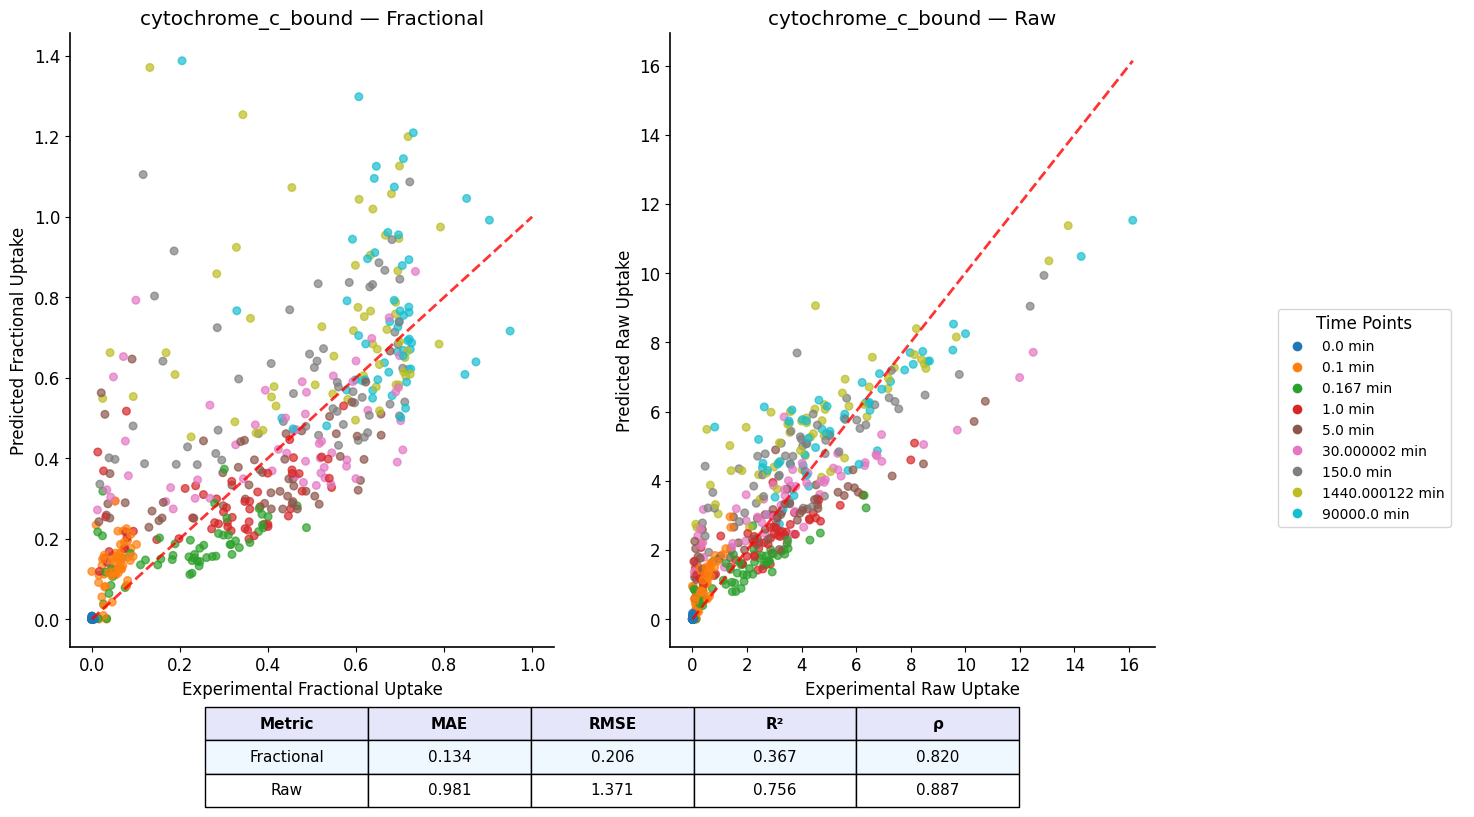

In [92]:
# @title Plot Accuracy

def calculate_metrics(actual, predicted):
    """Compute MAE, RMSE, R² and Spearman's ρ, ignoring NaNs."""
    a = np.array(actual)
    p = np.array(predicted)
    mask = ~np.isnan(a) & ~np.isnan(p)
    if not mask.any():
        return {'MAE': np.nan, 'RMSE': np.nan, 'R²': np.nan, 'ρ': np.nan}
    a, p = a[mask], p[mask]
    mae  = mean_absolute_error(a, p)
    rmse = np.sqrt(mean_squared_error(a, p))
    r2   = r2_score(a, p)
    rho  = spearmanr(a, p).correlation if len(a) > 1 else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2, 'ρ': rho}

def plot_stage2_results(json_file):
    """
    Load a Stage 2 JSON (with keys 'peptides', 'system') and
    plot fractional uptake (left) and raw uptake (right) with metrics
    displayed in a separate table below the graphs.
    """
    json_path = Path(json_file)
    if not json_path.exists():
        print(f"Error: JSON not found at {json_file}")
        return

    data = json.loads(json_path.read_text())
    frac_exp, frac_pred, raw_exp, raw_pred, time_points = [], [], [], [], []

    for pep in data['peptides']:
        # Get all relevant lists for the peptide, with defaults to avoid KeyErrors
        exposures = pep.get('exposures', [])
        experimental_frac = pep.get('experimental_frac', [])
        predicted_frac_corr = pep.get('predicted_frac_corr', [])
        experimental_raw = pep.get('experimental_raw', [])
        predicted_raw_corr = pep.get('predicted_raw_corr', [])

        # Find the minimum length among the lists
        min_len = min(
            len(exposures),
            len(experimental_frac),
            len(predicted_frac_corr),
            len(experimental_raw),
            len(predicted_raw_corr)
        )

        # Only extend the lists up to the minimum length to avoid mismatches
        frac_exp.extend(experimental_frac[:min_len])
        frac_pred.extend(predicted_frac_corr[:min_len])
        raw_exp.extend(experimental_raw[:min_len])
        raw_pred.extend(predicted_raw_corr[:min_len])
        time_points.extend(exposures[:min_len])

    df_frac = pd.DataFrame({'Actual': frac_exp, 'Predicted': frac_pred})
    df_raw  = pd.DataFrame({'Actual': raw_exp,  'Predicted': raw_pred})

    stats_frac = calculate_metrics(df_frac['Actual'], df_frac['Predicted'])
    stats_raw  = calculate_metrics(df_raw['Actual'],  df_raw['Predicted'])

    # plotting style
    plt.style.use('default')
    plt.rcParams.update({
        'font.size': 12,
        'axes.linewidth': 1.2,
        'figure.dpi': 100,
        'savefig.dpi': 300
    })

    # Create figure with subplots: 2 plots on top, 1 table below
    fig = plt.figure(figsize=(18, 10))

    # Create grid layout: 2 rows, 3 columns (extra column for legend)
    gs = fig.add_gridspec(3, 3, height_ratios=[3, 3, 1], width_ratios=[2, 2, 0.8], hspace=0.3, wspace=0.3)

    # Plot panels
    axL = fig.add_subplot(gs[0:2, 0])  # Left plot spans first 2 rows
    axR = fig.add_subplot(gs[0:2, 1])  # Right plot spans first 2 rows

    # Get unique time points and assign discrete colors
    unique_times = sorted(list(set(time_points)))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_times)))
    time_color_map = {time: colors[i] for i, time in enumerate(unique_times)}
    point_colors = [time_color_map[tp] for tp in time_points]

    # fractional uptake panel
    axL.scatter(df_frac['Actual'], df_frac['Predicted'],
               c=point_colors, alpha=0.7, s=30)
    axL.plot([0, 1], [0, 1], 'r--', lw=2, alpha=0.8)
    axL.set(
        xlabel='Experimental Fractional Uptake',
        ylabel='Predicted Fractional Uptake',
        title=f"{data['system']} — Fractional"
    )

    # raw uptake panel
    mn, mx = min(df_raw.min()), max(df_raw.max())
    axR.scatter(df_raw['Actual'], df_raw['Predicted'],
               c=point_colors, alpha=0.7, s=30)
    axR.plot([mn, mx], [mn, mx], 'r--', lw=2, alpha=0.8)
    axR.set(
        xlabel='Experimental Raw Uptake',
        ylabel='Predicted Raw Uptake',
        title=f"{data['system']} — Raw"
    )

    for ax in (axL, axR):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Remove the grid line

    # Create metrics table in the bottom subplot (spans 2 columns)
    ax_table = fig.add_subplot(gs[2, 0:2])
    ax_table.axis('off')  # Hide axes for the table

    # Create legend in the right column
    ax_legend = fig.add_subplot(gs[:, 2])
    ax_legend.axis('off')  # Hide axes for the legend

    # Create legend elements
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 markerfacecolor=time_color_map[time], markersize=8,
                                 label=f'{time} min') for time in unique_times]

    ax_legend.legend(handles=legend_elements, loc='center left',
                    title='Time Points', fontsize=10, title_fontsize=12)

    # Create table data
    table_data = [
        ['Metric', 'MAE', 'RMSE', 'R²', 'ρ'],
        ['Fractional', f"{stats_frac['MAE']:.3f}", f"{stats_frac['RMSE']:.3f}",
         f"{stats_frac['R²']:.3f}", f"{stats_frac['ρ']:.3f}"],
        ['Raw', f"{stats_raw['MAE']:.3f}", f"{stats_raw['RMSE']:.3f}",
         f"{stats_raw['R²']:.3f}", f"{stats_raw['ρ']:.3f}"]
    ]

    # Create table
    table = ax_table.table(
        cellText=table_data,
        cellLoc='center',
        loc='center',
        colWidths=[0.15, 0.15, 0.15, 0.15, 0.15]
    )

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Style header row
    for i in range(len(table_data[0])):
        table[(0, i)].set_facecolor('#E6E6FA')
        table[(0, i)].set_text_props(weight='bold')

    # Style data rows with alternating colors
    for i in range(1, len(table_data)):
        color = '#F0F8FF' if i % 2 == 1 else '#FFFFFF'
        for j in range(len(table_data[i])):
            table[(i, j)].set_facecolor(color)

    plt.tight_layout()
    plt.show()

# auto-run if OUT_DIR and SYSTEM_LABEL exist
if 'OUT_DIR' in globals() and 'SYSTEM_LABEL' in globals():
    plot_stage2_results(OUT_DIR / f"{SYSTEM_LABEL}_results_stage2.json")
else:
    print("Define OUT_DIR and SYSTEM_LABEL before plotting.")